In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.signal import find_peaks
from scipy.linalg import eig

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
U0_LIST     = np.linspace(0.01,0.05,CPU_CNT,endpoint=False)
N_VOLT      = 50000
TIME_STEP   = 1e-11
PLOT_NORM   = Normalize(vmin=1000*U0_LIST[0], vmax=1000*U0_LIST[-1])
CMAP        = plt.get_cmap('cividis')
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
# FOLDER      = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
# FOLDER      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/DC/size_volt/"
N_PARTICLES = [3,5,7,9,11]
MARKERS     = ['o','s','<','>','^']

def stretched_exp(t, tau, beta, I0):
    return I0*np.exp(-(t/tau)**beta)

### RC Time Constant

In [ ]:
tau_t = {}
for N_P in N_PARTICLES:
    topo = {"Nx": N_P,"Ny": N_P,
            "e_pos": [[(N_P-1)//2, 0],[0, 0],[N_P-1, 0],
                    [0, (N_P-1)//2],[N_P-1, (N_P-1)//2],
                    [0, N_P-1],[N_P-1, N_P-1],[(N_P-1)//2, N_P-1]],
            "electrode_type": ['constant']*8}
    
    sim_c   = Simulation(topo)
    sim_c.build_conductance_matrix()
    cap_m           = sim_c.get_capacitance_matrix()*1e-18
    g_m             = sim_c.get_conductance_matrix()[8:,8:]
    eigenvalues, _  = eig(g_m, cap_m)
    real_eigs       = np.real(eigenvalues)
    valid_eigs      = real_eigs[real_eigs > 1e-9]

    lambda_min = np.min(valid_eigs)
    tau_t[N_P] = 1.0 / lambda_min

### Load Relaxation Data

In [4]:
t       = np.arange(N_VOLT) * TIME_STEP
# y_d     = {}
# ye_d    = {}
# I_d     = {}
p_d     = {}
for N_NP in N_PARTICLES:
    # y           = np.array([pd.read_csv(f"{FOLDER}Nx={N_NP}_Ny={N_NP}_Ne=8_{V:.5f}.csv")['Observable'].values for V in U0_LIST]).T
    # y           = np.vstack([np.zeros(len(U0_LIST)),y])
    # y_e         = np.array([pd.read_csv(f"{FOLDER}Nx={N_NP}_Ny={N_NP}_Ne=8_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T
    # y_e         = np.vstack([np.zeros(len(U0_LIST)),y_e])
    # y_d[N_NP]   = y
    # ye_d[N_NP]  = y_e
    p           = [np.mean(pd.read_csv(f"{FOLDER}mean_state_Nx={N_NP}_Ny={N_NP}_Ne=8_{V:.5f}.csv").iloc[:,8:].values,axis=1) for V in U0_LIST]
    p_d[N_NP]   = p

### Mean-field Potentials

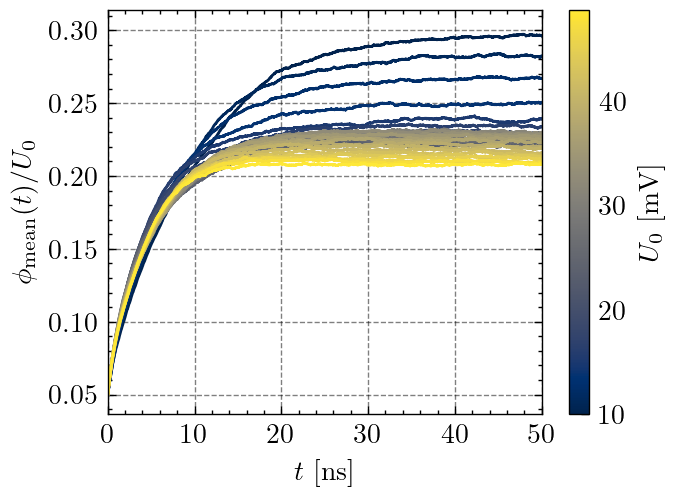

In [6]:
N_NP    = 9
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()[:-1]*1e9
    y_copy  = (p_d[N_NP][i].copy())/V
    ax.plot(t_copy, y_copy, color=CMAP(PLOT_NORM(V*1000)))
    
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$\\phi_\mathrm{mean}(t)/U_0$")
_ = ax.set_xlim(0, 5000*TIME_STEP*1e9)
# _ = ax.set_title("$N_{NP}"+f" = {N_NP**2}$")
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/png/relaxation/N={N_NP}_N={N_NP}_pot_vs_t.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/N={N_NP}_N={N_NP}_pot_vs_t.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/N={N_NP}_N={N_NP}_pot_vs_t.svg", transparent=True)

In [7]:
def tau_exp_fit(t, y, min_range=0.05, kohlrausch=True):
    signal_range = np.max(y) - np.min(y)
    if signal_range < min_range:
        return np.nan
    
    t_ns    = t * 1e9
    y_start = y[0]
    y_end   = np.median(y[int(len(y)*0.9):])
    A_fixed = y_end - y_start
    th_val  = y_start + 0.632 * A_fixed

    if A_fixed > 0:
        cross_idx = np.where(y > th_val)[0]
    else:
        cross_idx = np.where(y < th_val)[0]

    if len(cross_idx) > 0:
        guess_tau = t_ns[cross_idx[0]]
    else:
        guess_tau = 0.1

    if kohlrausch:
        def relaxation_model(t_vals, tau, beta):
            return y_start + A_fixed * (1 - np.exp(-(t_vals / tau)**beta))
        p0 = [guess_tau, 1.0]
        bounds = ([1e-6, 0.1], [np.inf, 1.0])
    else:
        def relaxation_model(t_vals, tau):
            return y_start + A_fixed * (1 - np.exp(-t_vals / tau))
        p0 = [guess_tau]
        bounds = (1e-6, np.inf)

    try:
        popt, pcov = curve_fit(relaxation_model, t_ns, y, p0=p0, bounds=bounds)
        if kohlrausch:
            tau_k   = popt[0]
            beta    = popt[1]
            tau_fit = (tau_k / beta) * gamma(1 / beta)
        else:
            tau_fit = popt[0]
        return tau_fit * 1e-9
    except RuntimeError:
        return np.nan

In [8]:
kohlrausch  = True
taus_d      = {}
for N_NP in N_PARTICLES:
    taus = []
    for i, V in enumerate(U0_LIST):
        t_copy  = t.copy()[:-1]
        y_copy  = (p_d[N_NP][i].copy())/V
        tau     = tau_exp_fit(t_copy, y_copy, kohlrausch=kohlrausch)
        taus.append(tau*1e9)
    taus_d[N_NP] = taus

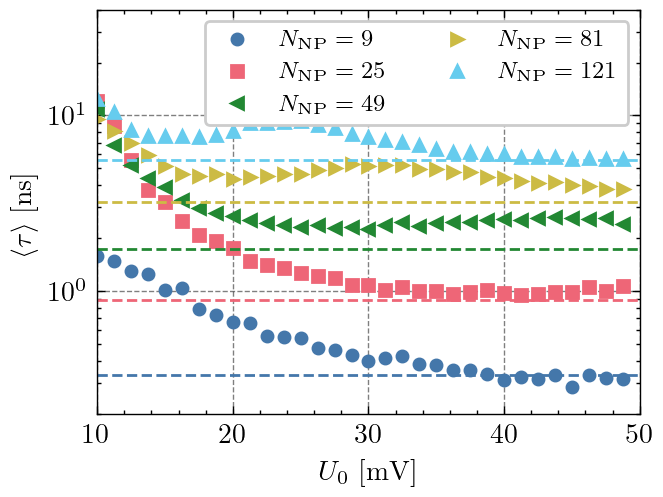

In [88]:
PLOT_NORM   = Normalize(vmin=N_PARTICLES[0]**2, vmax=N_PARTICLES[-1]**2)
CMAP        = plt.get_cmap('Dark2')

fig, ax = plt.subplots(dpi=200)
V_write = np.array(U0_LIST)*1000
marker  = ['o','s','<','>','^']
for i, N_NP in enumerate(N_PARTICLES):
    taus    = taus_d[N_NP]
    pp      = ax.plot(V_write, taus, marker=marker[i], ms=4, ls='', label='$N_\mathrm{NP} = '+f'{N_NP**2}$')#, color=CMAP(i))
    # pp      = ax.plot(V_write, taus, marker=marker[i], ms=4, ls='', label='$N_\mathrm{NP} = '+f'{N_NP**2}$', color=CMAP(PLOT_NORM(N_NP**2)))
    _       = ax.hlines(tau_t[N_NP]*1e9, 10, 50, colors=pp[0].get_color(), ls='--')
_ = ax.set_yscale('log')
_ = ax.set_xlim(10, 50)
_ = ax.set_ylim(0.2, 40)
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\langle\\tau\\rangle$ [ns]")
_ = ax.legend(fontsize='small', frameon=True, ncol=2, loc='upper right')

# sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label("$N_\mathrm{NP}$")

fig.savefig(f"plots/png/relaxation/tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/tau_vs_U.svg", transparent=True)

In [71]:
N_PARTICLES

[3, 5, 7, 9, 11]

In [10]:
idx = [4*i for i in range(7)]
pd.DataFrame([1e3/(2*np.pi*np.array(taus_d[N_NP])[idx]) for N_NP in N_PARTICLES], columns=V_write[idx], index=[N**2 for N in N_PARTICLES]).round(0)

,10.0,15.0,20.0,25.0,30.0,35.0,40.0
9,100.0,157.0,238.0,293.0,400.0,422.0,508.0
25,13.0,50.0,90.0,125.0,148.0,160.0,162.0
49,15.0,41.0,60.0,69.0,70.0,65.0,62.0
81,17.0,31.0,36.0,34.0,31.0,32.0,36.0
121,13.0,21.0,19.0,17.0,21.0,25.0,27.0


In [11]:
for i, N_NP in enumerate(N_PARTICLES):
    taus    = taus_d[N_NP]
    pp      = ax.plot(V_write, taus, marker=marker[i], ms=4, ls='', label='$N_\mathrm{NP} = '+f'{N_NP**2}$', color=CMAP(PLOT_NORM(N_NP**2)))
    _       = ax.hlines(tau_t[N_NP]*1e9, 10, 50, colors=pp[0].get_color(), ls='--')

[9.97036822]
[10.05002758]
[7.89496207]
[6.89503811]
[5.88905756]


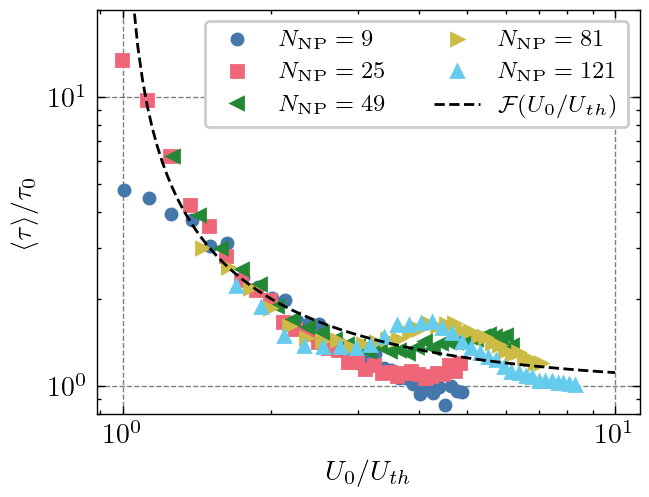

In [ ]:
def divergence_scaling(u, u_th):
    return u / (u - u_th)

PLOT_NORM   = Normalize(vmin=N_PARTICLES[0]**2, vmax=N_PARTICLES[-1]**2)
CMAP        = plt.get_cmap('cividis')

fig, ax = plt.subplots(dpi=200)
V_write = np.array(U0_LIST)*1000
marker  = ['o','s','<','>','^']
u_th_f  = []
for i, N_NP in enumerate(N_PARTICLES):
    taus    = taus_d[N_NP]
    taus_n  = taus/(tau_t[N_NP]*1e9)
    # mask    = (V_write > 14) & (taus_n < 20)
    mask    = (V_write > 14) & (taus_n < 10)

    p, cov  = curve_fit(divergence_scaling, V_write[mask], taus_n[mask])
    pp      = ax.plot(V_write/p[0], taus_n, marker=marker[i], ms=4, ls='', label='$N_\mathrm{NP} = '+f'{N_NP**2}$')#, color=CMAP(PLOT_NORM(N_NP**2)))
    print(p)
    u_th_f.append(p[0])
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlabel("$U_0 / U_{th}$")
_ = ax.set_ylabel("$\\langle\\tau\\rangle / \\tau_0$")

x_master = np.logspace(0.01, 1, 100) # From 1.01 to 100 on x-axis
y_master = x_master / (x_master - 1)
_   = ax.plot(x_master, y_master, color='black', ls='--', label='$\mathcal{F}(U_0/U_{th})$')
_   = ax.legend(fontsize='small', ncol=2)
_   = ax.set_ylim(0.8,20)

# sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label("$N_\mathrm{NP}$")

fig.savefig(f"plots/png/relaxation/tau_n_vs_U_Uth.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/tau_n_vs_U_Uth.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/t5au_n_vs_U_Uth.svg", transparent=True)

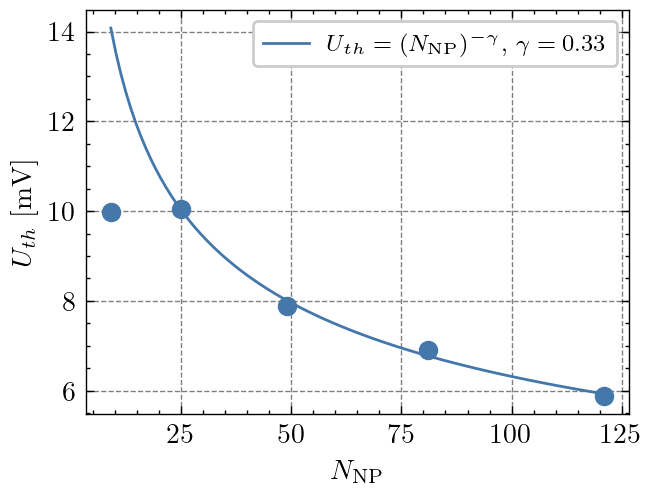

In [62]:
def power_law(x, a, gamma):
    return a * x**(-gamma)

sizes       = np.array([N**2 for N in N_PARTICLES])
x_fit       = np.linspace(min(sizes), max(sizes), 100)
popt, _     = curve_fit(power_law, sizes[1:], u_th_f[1:])
gamma_fit   = popt[1]

fig, ax = plt.subplots(dpi=200)
pp  = ax.plot(sizes, u_th_f, 'o')
_   = ax.plot(x_fit, power_law(x_fit, *popt), '-', color=pp[0].get_color(),
              label='$U_{th} = \\left(N_{\mathrm{NP}}\\right)^{-\\gamma}$'+f', $\\gamma = {np.round(gamma_fit,2)}$')
_ = ax.legend(fontsize='small')
_ = ax.set_xlabel("$N_\mathrm{NP}$")
_ = ax.set_ylabel("$U_{th}$ [mV]")
# ax.set_xscale('log')
# ax.set_yscale('log')

fig.savefig(f"plots/png/relaxation/Uth_vs_N_NP.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/Uth_vs_N_NP.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/Uth_vs_N_NP.svg", transparent=True)

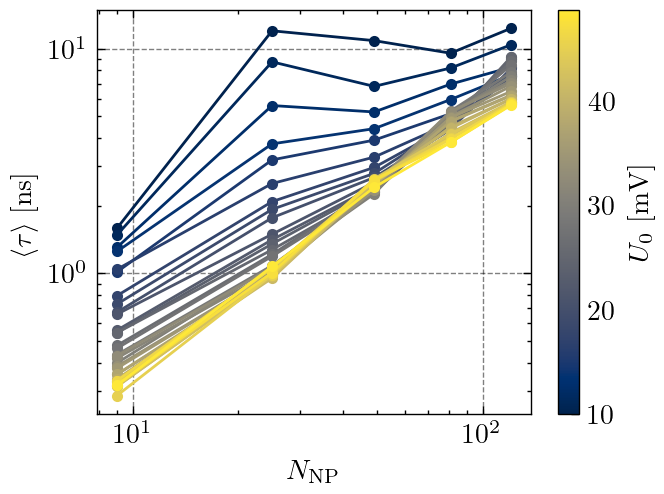

In [61]:
PLOT_NORM   = Normalize(vmin=U0_LIST[0]*1000, vmax=U0_LIST[-1]*1000)
CMAP        = plt.get_cmap('cividis')
x_vals      = [N**2 for N in N_PARTICLES]
fig, ax = plt.subplots(dpi=200)
for i in np.arange(0, len(U0_LIST), 1):
    ax.plot(x_vals, [taus_d[N][i] for N in N_PARTICLES], '.-', color=CMAP(PLOT_NORM(U0_LIST[i]*1000)))
# ax.plot([N**2 for N in N_PARTICLES], [tau_t[key]*1e9 for key in tau_t.keys()], 'o-')
ax.set_xlabel("$N_\mathrm{NP}$")
_ = ax.set_ylabel("$\\langle\\tau\\rangle$ [ns]")
plt.yscale('log')
plt.xscale('log')
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")
# fig.savefig(f"plots/png/relaxation/tau_vs_N_NP.png", transparent=False)

---

In [ ]:
N_NP    = 11
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()*1e9
    y_copy  = (y_d[N_NP][:,i].copy()*1e-9)/V
    ye_copy = (ye_d[N_NP][:,i].copy()*1e-9)/V
    ax.plot(t_copy, y_copy, color=CMAP(PLOT_NORM(V*1000)))
    
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G = I(t)/U_0$ [nS]")
_ = ax.set_xlim(0, 5000*TIME_STEP*1e9)
_ = ax.set_ylim(0, 2.0)
_ = ax.set_title("$N_{NP}"+f" = {N_NP**2}$")
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/png/relaxation/N={N_NP}_N={N_NP}_G_vs_t.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/N={N_NP}_N={N_NP}_G_vs_t.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/N={N_NP}_N={N_NP}_G_vs_t.svg", transparent=True)

In [ ]:
fig, ax     = plt.subplots(dpi=200)
V_write     = np.array(U0_LIST)*1000
V_smooth    = np.linspace(u_th_fit * 1.01, max(U0_LIST)*1000, 100)
tau_smooth  = tau_rc_fit * (V_smooth / (V_smooth - u_th_fit))
pp          = ax.plot(V_write, taus, marker='o', ms=4, ls='')
_ = ax.vlines(U_th*1e3, 0.1, 0.4, colors='black', label='$U_{th} = \\frac{e}{2C_{total}}$', ls=':')
_ = ax.hlines(tau_t*1e9, 8, 50, colors='black', label='$\\tau_{SET} = \\frac{R}{2} \cdot C_{total}$', ls='--')
_ = ax.plot(V_smooth, tau_smooth, color=pp[0].get_color(),
            label="$\\langle \\tau \\rangle = \\tau_{SET}\\left(\\frac{U_0}{U_0 - U_{th}} \\right)$\n$U_{th}"+f" = {np.round(u_th_fit,2)}$ mV")
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\langle\\tau\\rangle$ [ns]")
_ = ax.set_xlim(7.5, 50)
_ = ax.set_ylim(0.1, 0.4)
_ = ax.legend(fontsize='small')


# fig.savefig(f"plots/png/relaxation/SET_pot_tau_vs_U.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/SET_pot_tau_vs_U.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/SET_pot_tau_vs_U.svg", transparent=True)

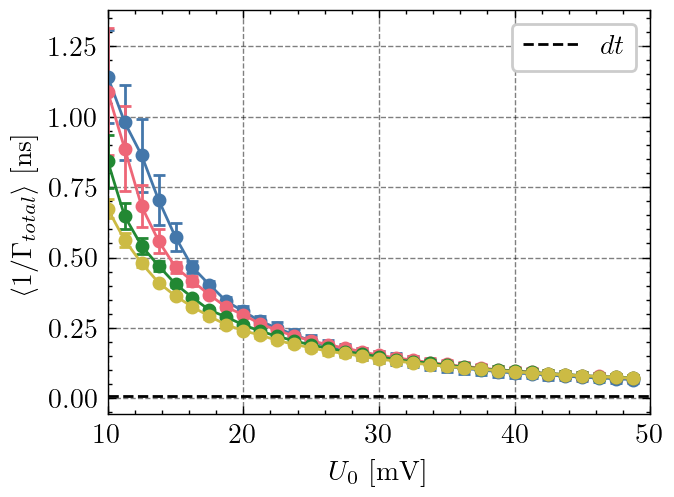

In [42]:
skip    = 0
idx     = 100
V_write = np.array(U0_LIST[skip:])*1000
fig, ax = plt.subplots(dpi=200)

for N_NP in N_PARTICLES:
    tau         = (1e9/np.sum(I_d[N_NP][:,:idx,:], axis=2))[skip:,:]
    tau_median  = np.median(tau, axis=1)
    tau_mean    = np.mean(tau, axis=1)
    tau_std     = np.std(tau, axis=1)
    tau_ci_u    = np.quantile(tau, 0.975, axis=1)
    tau_ci_l    = np.quantile(tau, 0.025, axis=1)

    # _ = ax.errorbar(V_write, tau_median, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
    _ = ax.errorbar(V_write, tau_mean, tau_std, marker='o', ms=4, capsize=2)
# _ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\langle 1/\\Gamma_{total} \\rangle$ [ns]")
_ = ax.set_xlim(10, 50)
# _ = ax.set_ylim(0.0009,1e1)
# ax.set_yscale('log')

fig.savefig(f"plots/png/relaxation/current_gamma_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/current_gamma_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/current_gamma_tau_vs_U.svg", transparent=True)

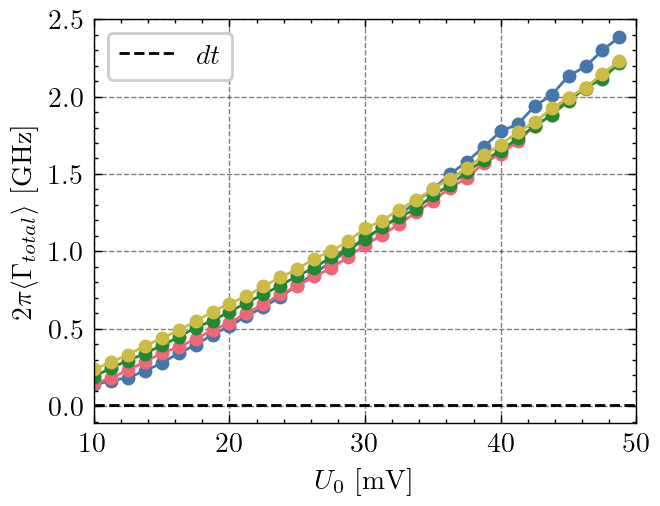

In [45]:
skip    = 0
idx     = 100
V_write = np.array(U0_LIST[skip:])*1000
fig, ax = plt.subplots(dpi=200)

for N_NP in N_PARTICLES:
    tau         = (1e9/np.sum(I_d[N_NP][:,:idx,:], axis=2))[skip:,:]
    tau_median  = np.median(tau, axis=1)
    tau_mean    = np.mean(tau, axis=1)
    tau_std     = np.std(tau, axis=1)
    tau_ci_u    = np.quantile(tau, 0.975, axis=1)
    tau_ci_l    = np.quantile(tau, 0.025, axis=1)

    # _ = ax.errorbar(V_write, tau_median, [tau_ci_l,tau_ci_u], marker='o', ms=4, capsize=2)
    _ = ax.errorbar(V_write, 1/(2*np.pi*tau_mean), marker='o', ms=4)
# _ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.hlines(TIME_STEP*1e9, 10, 50, colors='black', label='$dt$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$2\\pi\\langle \\Gamma_{total} \\rangle$ [GHz]")
_ = ax.set_xlim(10, 50)
# _ = ax.set_ylim(0.0009,1e1)
# ax.set_yscale('log')

fig.savefig(f"plots/png/relaxation/current_gamma_f_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/current_gamma_f_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/current_gamma_f_vs_U.svg", transparent=True)

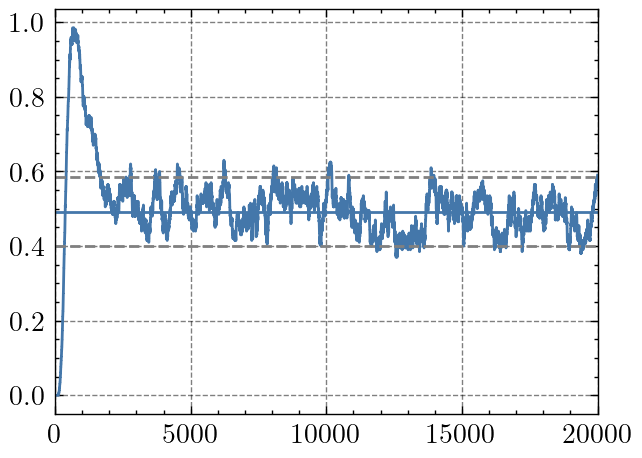

In [35]:
i       = 8
N_NP    = 11
n_max   = 20000
fig, ax = plt.subplots(dpi=200)
y_copy  = np.round(y_d[N_NP][:,i].copy()*1e-9,4)/U0_LIST[i]
ax.plot(y_copy)
ax.hlines(np.median(y_copy[:-1000]),0,n_max)
ax.hlines(np.quantile(y_copy[:-1000],0.05),0,n_max, color='grey', ls='dashed')
ax.hlines(np.quantile(y_copy[:-1000],0.95),0,n_max, color='grey', ls='dashed')
_ = ax.set_xlim(0, n_max)

### Time Constants

In [6]:
skip    = 0
min_con = 5
sat     = 1000
p_sat   = 0.63
taus_d  = {}
cvs_d   = {}
for N_NP in N_PARTICLES:
    taus    = []
    cvs     = []
    for i, V in enumerate(U0_LIST[skip:]):

        # Copy data
        t_copy  = t.copy()*1e9
        y_copy  = (y_d[N_NP][:,i+skip].copy()*1e-9)/V
        ye_copy = (ye_d[N_NP][:,i+skip].copy()*1e-9)/V

        # Get Saturation Values and Transient Part
        sat_mean = np.median(y_copy[-sat:])

        # threshold crossing: first index where y >= p_sat*sat_mean and persists for min_consec samples
        thresh  = p_sat * sat_mean
        above   = y_copy >= thresh

        # find first run of at least min_consec True
        idx_cut = None
        consec = 0
        for i, val in enumerate(above):
            if val:
                consec += 1
                if consec >= min_con:
                    idx_cut = i - (min_con - 1) + 1
                    break
            else:
                consec = 0
        
        t_plot  = t_copy[:idx_cut]
        y_plot  = y_copy[:idx_cut]
        
        # Get Tau and CV (model-free)
        # f       = (sat_mean - y_plot) / sat_mean
        f       = (np.max(y_plot) - y_plot) / np.max(y_plot)
        norm    = np.trapz(f, x=t_plot)
        tau     = np.trapz(t_plot * f, x=t_plot) / norm
        tau2    = np.trapz(t_plot**2 * f, x=t_plot) / norm
        sigma   = np.sqrt(tau2 - tau**2)
        cv      = sigma / tau

        # Append
        taus.append(tau)
        cvs.append(cv)
    taus_d[N_NP] = taus
    cvs_d[N_NP]  = cvs

/tmp/ipykernel_31731/509820737.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm    = np.trapz(f, x=t_plot)
/tmp/ipykernel_31731/509820737.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tau     = np.trapz(t_plot * f, x=t_plot) / norm
/tmp/ipykernel_31731/509820737.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tau2    = np.trapz(t_plot**2 * f, x=t_plot) / norm


In [8]:
N_PARTICLES

[3, 5, 7, 9]

[34.20879653  1.29302065]
[6.06717306e+03 2.70183742e+00]
[5.35270513e+03 2.72383626e+00]
[4.44525966e+03 2.70196432e+00]


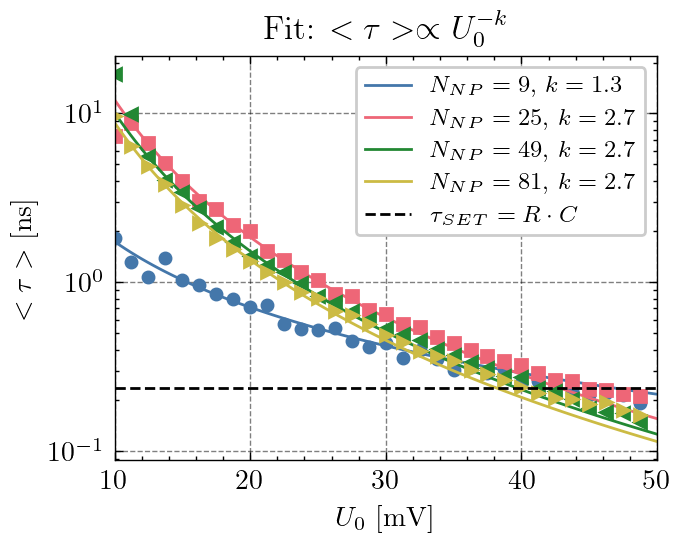

In [10]:
def power_law(x, A, k):
    return A*(x)**(-k)

min_V   = 12
max_V   = 40
fig, ax = plt.subplots(dpi=200)
V_write = np.array(U0_LIST[skip:])*1000
V_clean = V_write[(V_write < max_V) & ((V_write >= min_V))]
for i, N_NP in enumerate(N_PARTICLES):
    tau_clean   = np.array(taus_d[N_NP])[(V_write < max_V) & ((V_write >= min_V))]
    p, cov      = curve_fit(power_law, V_clean, tau_clean, bounds=[[0,0],[np.inf,np.inf]])
    print(p)
    V_fit       = np.linspace(10, 50, 100)
    tau_fit     = power_law(V_fit, *p)
    pp  = ax.plot(V_write, taus_d[N_NP], marker=MARKERS[i], ls='', ms=4)
    # _   = ax.plot(V_fit, tau_fit, label='$U_{th} = '+f'{p[1].round(1)}$ mV, $k = {p[1].round(1)}$', color=pp[0].get_color())
    _   = ax.plot(V_fit, tau_fit, label='$N_{NP} = '+f'{N_NP**2}$, $k = {p[1].round(1)}$', color=pp[0].get_color())
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.legend(fontsize='small')
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(10,50)
# _ = ax.set_xscale('log')
_ = ax.set_yscale('log')
# _ = ax.set_title("Fit: $<\\tau>\\propto (U_0 - U_{th})^{-k}$")
_ = ax.set_title("Fit: $<\\tau>\\propto U_0^{-k}$")

# fig.savefig(f"plots/png/relaxation/tau_vs_U.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/tau_vs_U.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/tau_vs_U.svg", transparent=True)

[34.20879653  1.29302065]
[6.06717306e+03 2.70183742e+00]
[5.35270513e+03 2.72383626e+00]
[4.44525966e+03 2.70196432e+00]


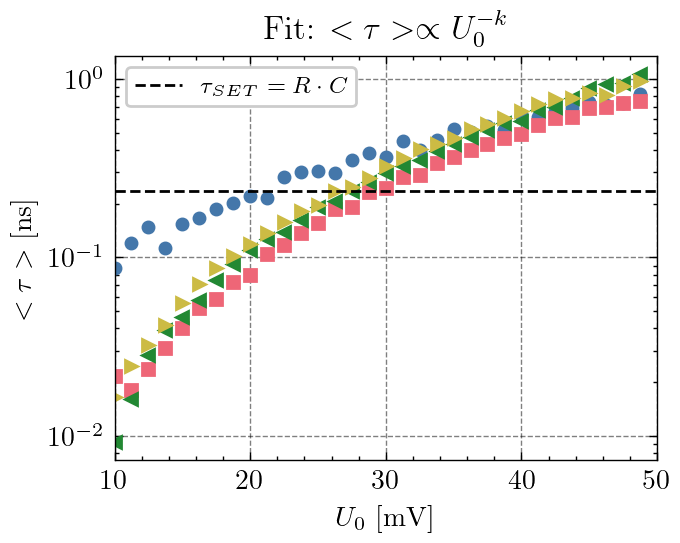

In [13]:
def power_law(x, A, k):
    return A*(x)**(-k)

min_V   = 12
max_V   = 40
fig, ax = plt.subplots(dpi=200)
V_write = np.array(U0_LIST[skip:])*1000
V_clean = V_write[(V_write < max_V) & ((V_write >= min_V))]
for i, N_NP in enumerate(N_PARTICLES):
    tau_clean   = np.array(taus_d[N_NP])[(V_write < max_V) & ((V_write >= min_V))]
    p, cov      = curve_fit(power_law, V_clean, tau_clean, bounds=[[0,0],[np.inf,np.inf]])
    print(p)
    V_fit       = np.linspace(10, 50, 100)
    tau_fit     = power_law(V_fit, *p)
    pp  = ax.plot(V_write, 1/(2*np.pi*np.array(taus_d[N_NP])), marker=MARKERS[i], ls='', ms=4)
    # _   = ax.plot(V_fit, tau_fit, label='$U_{th} = '+f'{p[1].round(1)}$ mV, $k = {p[1].round(1)}$', color=pp[0].get_color())
    # _   = ax.plot(V_fit, tau_fit, label='$N_{NP} = '+f'{N_NP**2}$, $k = {p[1].round(1)}$', color=pp[0].get_color())
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.legend(fontsize='small')
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(10,50)
# _ = ax.set_xscale('log')
_ = ax.set_yscale('log')
# _ = ax.set_title("Fit: $<\\tau>\\propto (U_0 - U_{th})^{-k}$")
_ = ax.set_title("Fit: $<\\tau>\\propto U_0^{-k}$")

# fig.savefig(f"plots/png/relaxation/tau_vs_U.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/tau_vs_U.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/tau_vs_U.svg", transparent=True)

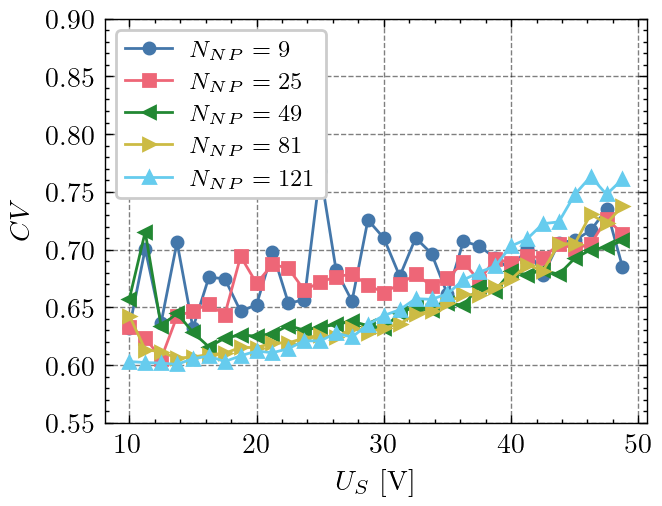

In [336]:
fig, ax = plt.subplots(dpi=200)
for i, N_NP in enumerate(N_PARTICLES):
    _ = ax.plot(np.array(U0_LIST[skip:])*1000, cvs_d[N_NP], marker=MARKERS[i], ls='-', ms=4, label='$N_{NP} = '+f'{N_NP**2}$')
_ = ax.set_xlabel("$U_S$ [V]")
_ = ax.set_ylabel("$CV$")
_ = ax.set_ylim(0.55,0.9)
_ = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/relaxation/cv_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/cv_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/cv_vs_U.svg", transparent=True)

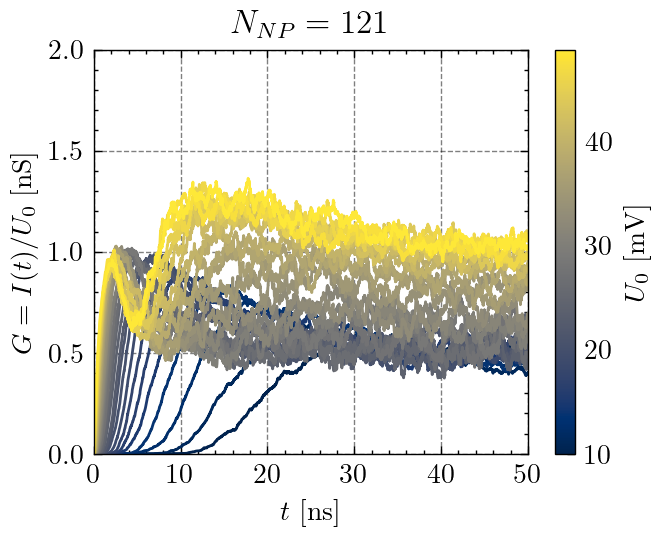

In [325]:
N_NP    = 11
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()*1e9
    y_copy  = (y_d[N_NP][:,i].copy()*1e-9)/V
    ye_copy = (ye_d[N_NP][:,i].copy()*1e-9)/V
    ax.plot(t_copy, y_copy, color=CMAP(PLOT_NORM(V*1000)))
    
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G = I(t)/U_0$ [nS]")
_ = ax.set_xlim(0, 5000*TIME_STEP*1e9)
_ = ax.set_ylim(0, 2.0)
_ = ax.set_title("$N_{NP}"+f" = {N_NP**2}$")
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/png/relaxation/N={N_NP}_N={N_NP}_G_vs_t.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/N={N_NP}_N={N_NP}_G_vs_t.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/N={N_NP}_N={N_NP}_G_vs_t.svg", transparent=True)

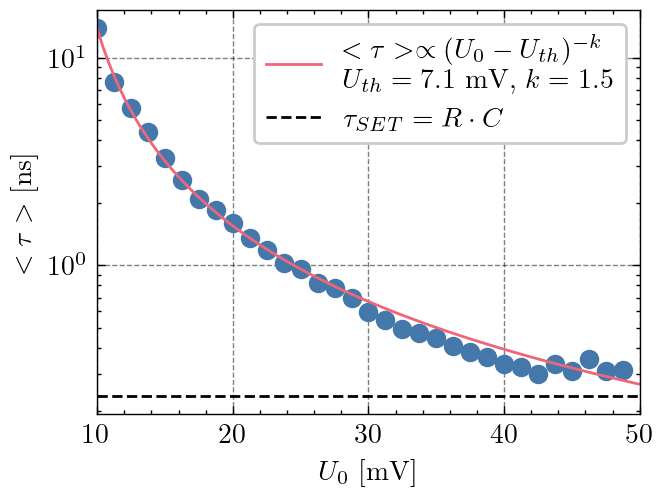

In [112]:
def power_law1(x, A, k, tau0):
    return tau0 + A*x**(-k)
def power_law2(x, A, k, V_th):
    return A*(x-V_th)**(-k)
def power_law3(x, A, k, tau0, V_th):
    return tau0 + A*(x-V_th)**(-k)

V_write     = np.array(U0_LIST[skip:])*1000
V_clean     = V_write[V_write < 40]
tau_clean   = np.array(taus)[V_write < 40]
p, cov      = curve_fit(power_law2, V_clean, tau_clean, bounds=[[0,0,0],[np.inf,np.inf,10]])
V_fit       = np.linspace(10, 50, 100)
tau_fit     = power_law2(V_fit, *p)

fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(U0_LIST[skip:])*1000, taus, 'o')#, label='$<\\tau> = \\frac{\\tau_K}{\\beta}\\Gamma(\\frac{1}{\\beta})$')
_ = ax.plot(V_fit, tau_fit, label='$<\\tau>\\propto (U_0 - U_{th})^{-k}$\n$U_{th} = '+f'{p[2].round(1)}$ mV, $k = {p[1].round(1)}$')
_ = ax.hlines(tau_t, 10, 50, colors='black', label='$\\tau_{SET} = R \cdot C$', ls='--')
_ = ax.legend()
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(10, 50)
_ = ax.set_yscale('log')

fig.savefig(f"plots/png/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/DC/N={N_PARTICLES}_N={N_PARTICLES}_tau_vs_U.svg", transparent=True)